In [1]:
import pandas as pd 
import numpy as np
import seaborn as sn 
%pylab inline 

DRAWING = True
IMG = "./figs/"
global_drawing_params = {"dpi": 300, "bbox_inches": "tight"}

Populating the interactive namespace from numpy and matplotlib


# Data Viz & Cleaning

In [2]:
data_o = pd.read_csv("data.arff", skiprows=19, header=None)
data_o.columns = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4", "E" ]
x_cols =  ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

The original paper describes ranges for min and max. Let's view our ranges. 

In [3]:
print("{:6}\t{:5}\t{:5}\t{:5}".format("Channel", "min", "mean", "max"))
for x in x_cols: 
    print("{:6}\t{:5.0f}\t{:5.0f}\t{:5.0f}".format(x, data_o[x].min(), data_o[x].mean(), data_o[x].max()))

Channel	min  	mean 	max  
AF3   	 1031	 4322	309231
F7    	 2831	 4010	 7805
F3    	 1040	 4264	 6881
FC5   	 2453	 4165	642564
T7    	 2090	 4342	 6474
P7    	 2768	 4644	362564
O1    	 2086	 4110	567179
O2    	 4567	 4616	 7264
P8    	 1358	 4219	265641
T8    	 1816	 4231	 6674
FC6   	 3273	 4202	 6823
F4    	 2258	 4279	 7003
F8    	   87	 4615	152308
AF4   	 1366	 4416	715897


We have some obvious discrepencies. Let's also view the graph of this data. 

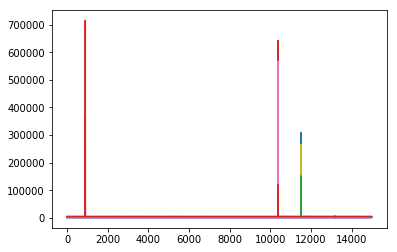

In [4]:
for i in data_o: 
    data_o[i].plot()

Evidently, these are the three transmission errors the paper referenced. So, let's clean that up, replacing by a mean of adjecent points

In [5]:
for i in range(0, 3): 
    for j, col in enumerate(x_cols): 
        amax = data_o[col].idxmax() 
        data_o.iloc[amax, j] = (data_o.iloc[amax - 1, j] + data_o.iloc[amax + 1, j]) / 2
        amin = data_o[col].idxmin() 
        data_o.iloc[amin, j] = (data_o.iloc[amin - 1, j] + data_o.iloc[amin + 1, j]) / 2


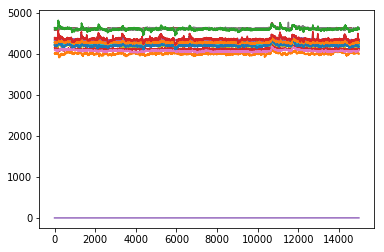

In [6]:
for i in data_o: 
    data_o[i].plot()

## Normalization 

Now we need to move it to center and normalize it. 

In [7]:
new = {}; 
for i in data_o:
    if i != "E": 
        new[i] = (data_o[i] - data_o[i].median())/data_o[i].std() 
    else: 
        new[i] = data_o[i] 
data = pd.DataFrame(new) 

## Viz 

We should see if this data is skewed in any way. A selective log-transform can be applied in presense of a skew to help normalize it. 

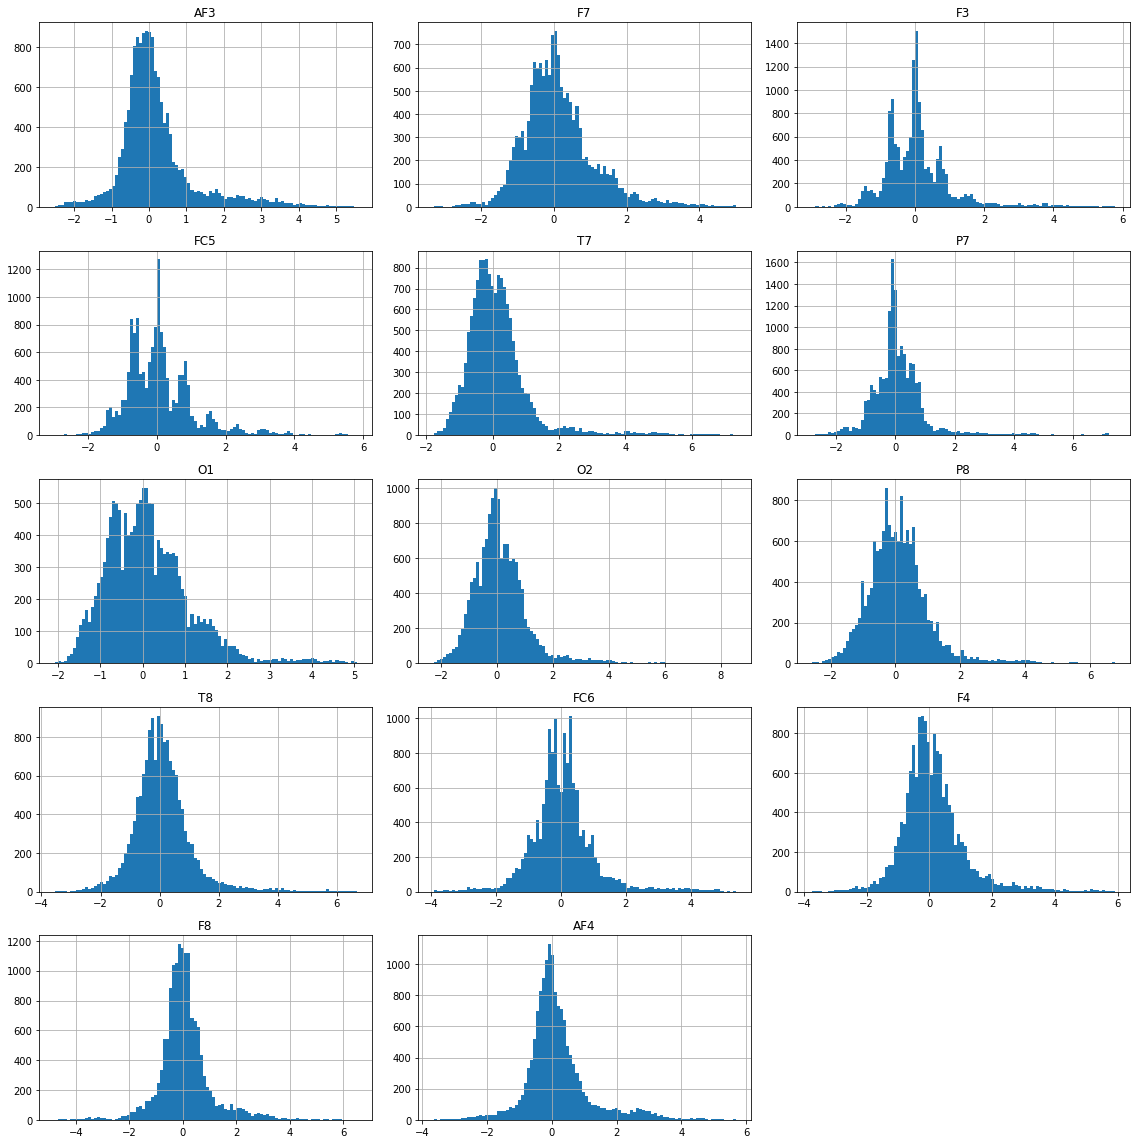

In [8]:
figshape = (5, 3)
fig, axs = plt.subplots(*figshape, figsize=(16, 16))
for i, j in enumerate(x_cols): 
    axind = np.unravel_index(i, figshape)
    ax = axs[axind[0]][axind[1]]
    data[j].hist(ax = ax, bins=100) 
    ax.set_title(j) 
for l in range(i + 1, np.prod(figshape)): 
    axind = np.unravel_index(l, figshape) 
    ax = axs[axind[0]][axind[1]]
    ax.set_axis_off() 
fig.tight_layout()

if DRAWING: 
    fig.savefig(IMG + "channel_histogram.png", **global_drawing_params)

We can see that there isn't much of a skew. 

# Tensorflow

The [original paper](http://suendermann.com/su/pdf/aihls2013.pdf) describes using a blending of the 40% with the [K-Star algorithm](http://sci2s.ugr.es/keel/pdf/algorithm/congreso/KStar.pdf). Let's see if we can beat that 

In [9]:
import tensorflow as tf

Our input is a length 14 vector and our output is a classification of 1 or 0 based on open or closed. The following construct lets us choose how many seconds we want. it's set to 117, so we have 1/117^2 aka 1 single input. 

In [10]:
shape = data_o.shape[0] // (117 * 117) , 14 

## Setup Input Function 

The algorithm mostly comes into play when we have history included. 

In [11]:
from sklearn.model_selection import train_test_split

input_vector = np.zeros((data_o.shape[0] - shape[0], np.prod(shape)))
output_vector = np.zeros((data_o.shape[0] - shape[0], 1))

for i in range(shape[0], data_o.shape[0]): 
    input_vector[i - shape[0], :] = data.iloc[i - shape[0]:i, :-1].values.flatten()
    output_vector[i - shape[0]] = data['E'][i].astype(int)

train_x, test_x, train_y, test_y = train_test_split(input_vector, output_vector)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": train_x}, 
    y = train_y.astype(int), 
    batch_size = 50, 
    num_epochs = None, 
    shuffle = True
)

## Define Model 

In [18]:
def model_fn(features, labels, mode, **params): 
    # the input is a tensor 
    dense1 = tf.layers.dense( 
        inputs = features['x'], 
        units = int(np.sqrt(np.prod(shape))) * 2, 
        activation = tf.nn.sigmoid, 
        name="Input_Activation"
    )
    # Reactivate with softplus to let any startlingly high inputs
    # be amplified 
    second_seg = tf.layers.dense(
        inputs = dense1,
        units = int(np.sqrt(np.prod(shape))), 
        activation = tf.nn.softplus, 
        name="Softplus"
    )

    # Dropout -- softplus seems dangerous  
    dropout = tf.layers.dropout (
        inputs = second_seg, 
        rate = 0.25, 
        training= mode == tf.estimator.ModeKeys.TRAIN, 
        name="Dropout"
    )

    # Reactivate the softplus  
    dense2 = tf.layers.dense(
        inputs = dropout,
        units = int(np.sqrt(np.prod(shape))), 
        activation = tf.nn.tanh, 
        name="Dense_Layer_sqrt_X"
    )
    # And once more, with an arbitrarly large layer. 
    dense3 = tf.layers.dense (
        inputs = dense2, 
        units = 1000, 
        activation = tf.nn.tanh, 
        name="Dense_Layer_1000"
    )
    #Compact this with ReLU into our output.  
    res = tf.layers.dense (
        inputs = dense3, 
        activation = tf.nn.relu,
        units = 2,
        name="Output"
    )
    predictions = {
        'classes': tf.argmax(input=res, axis=1), 
        "probabilities": tf.nn.softmax(res, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT: 
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = res)
    
    tf.summary.scalar("loss", loss) 
    tf.summary.tensor_summary("result", res) 
    if mode == tf.estimator.ModeKeys.TRAIN: 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005)
        train_op = optimizer.minimize(
            loss = loss, 
            global_step = tf.train.get_global_step() 
        )
        return tf.estimator.EstimatorSpec(mode = mode, loss=loss, train_op = train_op)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy (
            labels = labels, 
            predictions = predictions["classes"]
        )
    }
    
    return tf.estimator.EstimatorSpec(
    mode = mode, loss=loss, eval_metric_ops = eval_metric_ops)    

In [19]:
log_dir = "model_cache" 
tf.gfile.MakeDirs(log_dir)

eye_classifier = tf.estimator.Estimator(
    model_fn = model_fn, 
    model_dir = log_dir
)
eye_classifier.train(input_fn= train_input_fn, steps=100000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from model_cache/model.ckpt-100000
INFO:tensorflow:Saving checkpoints for 100001 into model_cache/model.ckpt.
INFO:tensorflow:loss = 0.126021966338, step = 100001
INFO:tensorflow:global_step/sec: 345.306
INFO:tensorflow:loss = 0.139586538076, step = 100101 (0.291 sec)
INFO:tensorflow:global_step/sec: 370.747
INFO:tensorflow:loss = 0.0978495404124, step = 100201 (0.270 sec)
INFO:tensorflow:global_step/sec: 374.46
INFO:tensorflow:loss = 0.0983228906989, step = 100301 (0.267 sec)
INFO:tensorflow:global_step/sec: 394.308
INFO:tensorflow:loss = 0.305084615946, step = 100401 (0.254 sec)
INFO:tensorflow:global_step/sec: 351.833
INFO:tensorflow:loss = 0.251664072275, step = 100501 (0.284 sec)
INFO:tensorflow:global_step/sec: 378.74
INFO:tensorflow:loss = 0.248760640621, step = 100601 (0.264 sec)
INFO:tensorflow:global_step/sec: 387.993
INFO:ten

INFO:tensorflow:global_step/sec: 290.286
INFO:tensorflow:loss = 0.181213781238, step = 107601 (0.344 sec)
INFO:tensorflow:global_step/sec: 301.171
INFO:tensorflow:loss = 0.181059017777, step = 107701 (0.332 sec)
INFO:tensorflow:global_step/sec: 329.186
INFO:tensorflow:loss = 0.16717377305, step = 107801 (0.304 sec)
INFO:tensorflow:global_step/sec: 321.879
INFO:tensorflow:loss = 0.182702869177, step = 107901 (0.310 sec)
INFO:tensorflow:global_step/sec: 312.784
INFO:tensorflow:loss = 0.153329834342, step = 108001 (0.320 sec)
INFO:tensorflow:global_step/sec: 324.437
INFO:tensorflow:loss = 0.125651568174, step = 108101 (0.308 sec)
INFO:tensorflow:global_step/sec: 304.856
INFO:tensorflow:loss = 0.153410896659, step = 108201 (0.328 sec)
INFO:tensorflow:global_step/sec: 315.742
INFO:tensorflow:loss = 0.153401836753, step = 108301 (0.317 sec)
INFO:tensorflow:global_step/sec: 396.735
INFO:tensorflow:loss = 0.140065908432, step = 108401 (0.253 sec)
INFO:tensorflow:global_step/sec: 344.443
INFO:t

INFO:tensorflow:global_step/sec: 256.828
INFO:tensorflow:loss = 0.154406234622, step = 115401 (0.390 sec)
INFO:tensorflow:global_step/sec: 278.708
INFO:tensorflow:loss = 0.20937782526, step = 115501 (0.358 sec)
INFO:tensorflow:global_step/sec: 273.181
INFO:tensorflow:loss = 0.1690338552, step = 115601 (0.366 sec)
INFO:tensorflow:global_step/sec: 327.988
INFO:tensorflow:loss = 0.167712762952, step = 115701 (0.305 sec)
INFO:tensorflow:global_step/sec: 316.037
INFO:tensorflow:loss = 0.197714745998, step = 115801 (0.317 sec)
INFO:tensorflow:global_step/sec: 248.83
INFO:tensorflow:loss = 0.209222018719, step = 115901 (0.403 sec)
INFO:tensorflow:global_step/sec: 228.556
INFO:tensorflow:loss = 0.113901168108, step = 116001 (0.436 sec)
INFO:tensorflow:global_step/sec: 246.497
INFO:tensorflow:loss = 0.127338707447, step = 116101 (0.406 sec)
INFO:tensorflow:global_step/sec: 248.153
INFO:tensorflow:loss = 0.153422787786, step = 116201 (0.404 sec)
INFO:tensorflow:global_step/sec: 262.6
INFO:tensor

INFO:tensorflow:global_step/sec: 301.295
INFO:tensorflow:loss = 0.139364764094, step = 123201 (0.333 sec)
INFO:tensorflow:global_step/sec: 284.1
INFO:tensorflow:loss = 0.182003751397, step = 123301 (0.354 sec)
INFO:tensorflow:global_step/sec: 246.712
INFO:tensorflow:loss = 0.195150449872, step = 123401 (0.404 sec)
INFO:tensorflow:global_step/sec: 249.056
INFO:tensorflow:loss = 0.181246951222, step = 123501 (0.402 sec)
INFO:tensorflow:global_step/sec: 245.576
INFO:tensorflow:loss = 0.153533861041, step = 123601 (0.406 sec)
INFO:tensorflow:global_step/sec: 289.112
INFO:tensorflow:loss = 0.114577181637, step = 123701 (0.346 sec)
INFO:tensorflow:global_step/sec: 327.009
INFO:tensorflow:loss = 0.167122066021, step = 123801 (0.305 sec)
INFO:tensorflow:global_step/sec: 260.775
INFO:tensorflow:loss = 0.156145587564, step = 123901 (0.384 sec)
INFO:tensorflow:global_step/sec: 232.145
INFO:tensorflow:loss = 0.22348369658, step = 124001 (0.431 sec)
INFO:tensorflow:global_step/sec: 312.848
INFO:ten

INFO:tensorflow:global_step/sec: 346.134
INFO:tensorflow:loss = 0.195126548409, step = 131001 (0.289 sec)
INFO:tensorflow:global_step/sec: 314.642
INFO:tensorflow:loss = 0.0846406519413, step = 131101 (0.318 sec)
INFO:tensorflow:global_step/sec: 317.262
INFO:tensorflow:loss = 0.228835627437, step = 131201 (0.315 sec)
INFO:tensorflow:global_step/sec: 365.722
INFO:tensorflow:loss = 0.154516771436, step = 131301 (0.273 sec)
INFO:tensorflow:global_step/sec: 344.735
INFO:tensorflow:loss = 0.180882751942, step = 131401 (0.290 sec)
INFO:tensorflow:global_step/sec: 308.387
INFO:tensorflow:loss = 0.153182029724, step = 131501 (0.324 sec)
INFO:tensorflow:global_step/sec: 361.198
INFO:tensorflow:loss = 0.167698189616, step = 131601 (0.277 sec)
INFO:tensorflow:global_step/sec: 373.921
INFO:tensorflow:loss = 0.167078360915, step = 131701 (0.267 sec)
INFO:tensorflow:global_step/sec: 368.691
INFO:tensorflow:loss = 0.236565709114, step = 131801 (0.271 sec)
INFO:tensorflow:global_step/sec: 388.872
INFO

INFO:tensorflow:global_step/sec: 365.087
INFO:tensorflow:loss = 0.168407261372, step = 138801 (0.274 sec)
INFO:tensorflow:global_step/sec: 390.869
INFO:tensorflow:loss = 0.180929854512, step = 138901 (0.256 sec)
INFO:tensorflow:global_step/sec: 362.501
INFO:tensorflow:loss = 0.140321016312, step = 139001 (0.276 sec)
INFO:tensorflow:global_step/sec: 391.102
INFO:tensorflow:loss = 0.142765775323, step = 139101 (0.256 sec)
INFO:tensorflow:global_step/sec: 362.174
INFO:tensorflow:loss = 0.139498189092, step = 139201 (0.277 sec)
INFO:tensorflow:global_step/sec: 222.609
INFO:tensorflow:loss = 0.208467841148, step = 139301 (0.450 sec)
INFO:tensorflow:global_step/sec: 237.965
INFO:tensorflow:loss = 0.140580534935, step = 139401 (0.419 sec)
INFO:tensorflow:global_step/sec: 228.551
INFO:tensorflow:loss = 0.0846799537539, step = 139501 (0.438 sec)
INFO:tensorflow:global_step/sec: 305.285
INFO:tensorflow:loss = 0.208582252264, step = 139601 (0.328 sec)
INFO:tensorflow:global_step/sec: 249.479
INFO

INFO:tensorflow:loss = 0.170909881592, step = 146501 (0.255 sec)
INFO:tensorflow:global_step/sec: 364.232
INFO:tensorflow:loss = 0.167255744338, step = 146601 (0.275 sec)
INFO:tensorflow:global_step/sec: 393.652
INFO:tensorflow:loss = 0.182721942663, step = 146701 (0.254 sec)
INFO:tensorflow:global_step/sec: 372.277
INFO:tensorflow:loss = 0.111754566431, step = 146801 (0.269 sec)
INFO:tensorflow:global_step/sec: 350.802
INFO:tensorflow:loss = 0.222459733486, step = 146901 (0.285 sec)
INFO:tensorflow:global_step/sec: 358.699
INFO:tensorflow:loss = 0.194940418005, step = 147001 (0.279 sec)
INFO:tensorflow:global_step/sec: 371.23
INFO:tensorflow:loss = 0.181191146374, step = 147101 (0.269 sec)
INFO:tensorflow:global_step/sec: 388.428
INFO:tensorflow:loss = 0.180756852031, step = 147201 (0.257 sec)
INFO:tensorflow:global_step/sec: 393.241
INFO:tensorflow:loss = 0.139512971044, step = 147301 (0.254 sec)
INFO:tensorflow:global_step/sec: 394.893
INFO:tensorflow:loss = 0.167603224516, step = 1

INFO:tensorflow:global_step/sec: 380.402
INFO:tensorflow:loss = 0.194643348455, step = 154301 (0.263 sec)
INFO:tensorflow:global_step/sec: 392.318
INFO:tensorflow:loss = 0.20878110826, step = 154401 (0.255 sec)
INFO:tensorflow:global_step/sec: 387.926
INFO:tensorflow:loss = 0.181244671345, step = 154501 (0.258 sec)
INFO:tensorflow:global_step/sec: 376.151
INFO:tensorflow:loss = 0.153195604682, step = 154601 (0.266 sec)
INFO:tensorflow:global_step/sec: 391.406
INFO:tensorflow:loss = 0.26491317153, step = 154701 (0.255 sec)
INFO:tensorflow:global_step/sec: 388.945
INFO:tensorflow:loss = 0.139259621501, step = 154801 (0.257 sec)
INFO:tensorflow:global_step/sec: 386.692
INFO:tensorflow:loss = 0.18203291297, step = 154901 (0.259 sec)
INFO:tensorflow:global_step/sec: 370.465
INFO:tensorflow:loss = 0.143461048603, step = 155001 (0.270 sec)
INFO:tensorflow:global_step/sec: 347.034
INFO:tensorflow:loss = 0.278779476881, step = 155101 (0.288 sec)
INFO:tensorflow:global_step/sec: 363.472
INFO:ten

INFO:tensorflow:global_step/sec: 366.41
INFO:tensorflow:loss = 0.222450003028, step = 162101 (0.273 sec)
INFO:tensorflow:global_step/sec: 381.032
INFO:tensorflow:loss = 0.208587691188, step = 162201 (0.263 sec)
INFO:tensorflow:global_step/sec: 373.312
INFO:tensorflow:loss = 0.208696931601, step = 162301 (0.268 sec)
INFO:tensorflow:global_step/sec: 378.467
INFO:tensorflow:loss = 0.222589969635, step = 162401 (0.264 sec)
INFO:tensorflow:global_step/sec: 399.385
INFO:tensorflow:loss = 0.181397482753, step = 162501 (0.250 sec)
INFO:tensorflow:global_step/sec: 389.132
INFO:tensorflow:loss = 0.154457867146, step = 162601 (0.257 sec)
INFO:tensorflow:global_step/sec: 379.251
INFO:tensorflow:loss = 0.194822117686, step = 162701 (0.264 sec)
INFO:tensorflow:global_step/sec: 369.749
INFO:tensorflow:loss = 0.153069481254, step = 162801 (0.270 sec)
INFO:tensorflow:global_step/sec: 367.72
INFO:tensorflow:loss = 0.126678049564, step = 162901 (0.272 sec)
INFO:tensorflow:global_step/sec: 382.207
INFO:te

INFO:tensorflow:loss = 0.139438584447, step = 169801 (0.274 sec)
INFO:tensorflow:global_step/sec: 367.514
INFO:tensorflow:loss = 0.223665714264, step = 169901 (0.272 sec)
INFO:tensorflow:global_step/sec: 378.787
INFO:tensorflow:loss = 0.139561519027, step = 170001 (0.264 sec)
INFO:tensorflow:global_step/sec: 391.63
INFO:tensorflow:loss = 0.112313687801, step = 170101 (0.256 sec)
INFO:tensorflow:global_step/sec: 352.418
INFO:tensorflow:loss = 0.299514830112, step = 170201 (0.284 sec)
INFO:tensorflow:global_step/sec: 396.242
INFO:tensorflow:loss = 0.298314779997, step = 170301 (0.252 sec)
INFO:tensorflow:global_step/sec: 371.154
INFO:tensorflow:loss = 0.195429593325, step = 170401 (0.270 sec)
INFO:tensorflow:global_step/sec: 390.017
INFO:tensorflow:loss = 0.194580838084, step = 170501 (0.256 sec)
INFO:tensorflow:global_step/sec: 383.449
INFO:tensorflow:loss = 0.194694191217, step = 170601 (0.261 sec)
INFO:tensorflow:global_step/sec: 402.246
INFO:tensorflow:loss = 0.303452372551, step = 1

INFO:tensorflow:global_step/sec: 390.088
INFO:tensorflow:loss = 0.139455929399, step = 177601 (0.256 sec)
INFO:tensorflow:global_step/sec: 316.602
INFO:tensorflow:loss = 0.125845998526, step = 177701 (0.316 sec)
INFO:tensorflow:global_step/sec: 387.828
INFO:tensorflow:loss = 0.222689837217, step = 177801 (0.258 sec)
INFO:tensorflow:global_step/sec: 330.567
INFO:tensorflow:loss = 0.354909926653, step = 177901 (0.302 sec)
INFO:tensorflow:global_step/sec: 378.845
INFO:tensorflow:loss = 0.223257064819, step = 178001 (0.264 sec)
INFO:tensorflow:global_step/sec: 328.775
INFO:tensorflow:loss = 0.18109074235, step = 178101 (0.304 sec)
INFO:tensorflow:global_step/sec: 367.727
INFO:tensorflow:loss = 0.126976549625, step = 178201 (0.272 sec)
INFO:tensorflow:global_step/sec: 329.912
INFO:tensorflow:loss = 0.125815927982, step = 178301 (0.303 sec)
INFO:tensorflow:global_step/sec: 373.964
INFO:tensorflow:loss = 0.181379601359, step = 178401 (0.267 sec)
INFO:tensorflow:global_step/sec: 343.537
INFO:t

INFO:tensorflow:global_step/sec: 338.573
INFO:tensorflow:loss = 0.208747088909, step = 185401 (0.296 sec)
INFO:tensorflow:global_step/sec: 358.533
INFO:tensorflow:loss = 0.140755861998, step = 185501 (0.278 sec)
INFO:tensorflow:global_step/sec: 362.237
INFO:tensorflow:loss = 0.127677500248, step = 185601 (0.276 sec)
INFO:tensorflow:global_step/sec: 374.009
INFO:tensorflow:loss = 0.114600583911, step = 185701 (0.267 sec)
INFO:tensorflow:global_step/sec: 374.252
INFO:tensorflow:loss = 0.181819215417, step = 185801 (0.267 sec)
INFO:tensorflow:global_step/sec: 389.379
INFO:tensorflow:loss = 0.195089414716, step = 185901 (0.257 sec)
INFO:tensorflow:global_step/sec: 377.574
INFO:tensorflow:loss = 0.12752585113, step = 186001 (0.265 sec)
INFO:tensorflow:global_step/sec: 389.09
INFO:tensorflow:loss = 0.195498481393, step = 186101 (0.257 sec)
INFO:tensorflow:global_step/sec: 379.113
INFO:tensorflow:loss = 0.209120094776, step = 186201 (0.264 sec)
INFO:tensorflow:global_step/sec: 354.746
INFO:te

INFO:tensorflow:loss = 0.168183401227, step = 193101 (0.265 sec)
INFO:tensorflow:global_step/sec: 335.998
INFO:tensorflow:loss = 0.139403671026, step = 193201 (0.297 sec)
INFO:tensorflow:global_step/sec: 393.482
INFO:tensorflow:loss = 0.167997002602, step = 193301 (0.254 sec)
INFO:tensorflow:global_step/sec: 385.569
INFO:tensorflow:loss = 0.153400957584, step = 193401 (0.260 sec)
INFO:tensorflow:global_step/sec: 370.129
INFO:tensorflow:loss = 0.125499904156, step = 193501 (0.270 sec)
INFO:tensorflow:global_step/sec: 350.997
INFO:tensorflow:loss = 0.125934556127, step = 193601 (0.286 sec)
INFO:tensorflow:global_step/sec: 384.855
INFO:tensorflow:loss = 0.127091631293, step = 193701 (0.259 sec)
INFO:tensorflow:global_step/sec: 371.382
INFO:tensorflow:loss = 0.180905908346, step = 193801 (0.269 sec)
INFO:tensorflow:global_step/sec: 383.893
INFO:tensorflow:loss = 0.194653570652, step = 193901 (0.261 sec)
INFO:tensorflow:global_step/sec: 380.949
INFO:tensorflow:loss = 0.195211410522, step = 

In [20]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn (
    x = {"x": test_x}, 
    y = test_y.astype(int), 
    num_epochs = 5, 
    shuffle = True
)

eval_results = eye_classifier.evaluate(input_fn = eval_input_fn) 
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-05-12-15:30:23
INFO:tensorflow:Restoring parameters from model_cache/model.ckpt-200000
INFO:tensorflow:Finished evaluation at 2018-05-12-15:30:23
INFO:tensorflow:Saving dict for global step 200000: accuracy = 0.999199, global_step = 200000, loss = 0.0174327
{'accuracy': 0.99919891, 'loss': 0.017432725, 'global_step': 200000}
